In [ ]:
# I used this block to dump network-network connectivity averages into a csv sheet. there was a separate one
# that put the individual-level networks into a different csv sheet. anyway, the point is, you probably never
# need to run this block again, but for full analytic transparency, here is how I made it:

# import pandas as pd
# from joblib import Parallel, delayed
# from tqdm import tqdm  

# # Load the flattened vectors CSV (adjust the path to your file)
# vectors_path = 'upper_triangle_vectors.csv'
# vectors_df = pd.read_csv(vectors_path)

# # Load the node network assignments from the NodeOrder.csv
# node_order_path = 'NodeOrder.csv'
# node_order_df = pd.read_csv(node_order_path, header=None)

# # Extract the network labels from the second row
# network_assignments = node_order_df.iloc[1].values  

# # Unique networks
# unique_networks = pd.unique(network_assignments)

# # Precompute node masks for each network
# network_masks = {network: [i for i, net in enumerate(network_assignments) if net == network] for network in unique_networks}

# # Function to calculate within-network and between-network connectivity for a single group
# def calculate_connectivity_for_group(group_data, target, session, network_1, network_2, network_masks):
#     nodes_in_network_1 = network_masks[network_1]
#     nodes_in_network_2 = network_masks[network_2]

#     if network_1 == network_2:
#         # Calculate within-network connectivity
#         within_values = group_data[
#             (group_data['node_1'].isin(nodes_in_network_1)) & (group_data['node_2'].isin(nodes_in_network_1))
#         ]['value'].mean()
#         return {
#             'target': target,
#             'session': session,
#             'network_1': network_1,
#             'network_2': network_1,
#             'average_connectivity': within_values
#         }
#     else:
#         # Calculate between-network connectivity
#         between_values = group_data[
#             (group_data['node_1'].isin(nodes_in_network_1)) & (group_data['node_2'].isin(nodes_in_network_2))
#         ]['value'].mean()
#         return {
#             'target': target,
#             'session': session,
#             'network_1': network_1,
#             'network_2': network_2,
#             'average_connectivity': between_values
#         }

# # Main function to calculate within-network and between-network connectivity averaged by target and session
# def calculate_avg_connectivity_by_target_time(vectors_df, network_masks, unique_networks):
#     results = []
#     grouped = vectors_df.groupby(['target', 'session'])

#     # tqdm progress bar to track the processing of each group
#     grouped = tqdm(grouped, desc="Processing groups", total=len(grouped))

#     # Use parallel processing with joblib
#     def process_group(target, session, group_data):
#         group_results = []
#         for network_1 in unique_networks:
#             # Calculate within-network connectivity
#             group_results.append(calculate_connectivity_for_group(group_data, target, session, network_1, network_1, network_masks))

#             # Calculate between-network connectivity
#             for network_2 in unique_networks:
#                 if network_1 != network_2:
#                     group_results.append(calculate_connectivity_for_group(group_data, target, session, network_1, network_2, network_masks))

#         return group_results

#     # Parallelize the processing of each group
#     all_results = Parallel(n_jobs=-1)(delayed(process_group)(target, session, group_data) for (target, session), group_data in grouped)
    
#     # Flatten the list of results
#     for group in all_results:
#         results.extend(group)
    
#     return pd.DataFrame(results)

# # Run the calculation
# avg_connectivity_by_target_time_df = calculate_avg_connectivity_by_target_time(vectors_df, network_masks, unique_networks)

# # Output the results
# print(avg_connectivity_by_target_time_df)

# save_path = 'network_connectivity_averages.csv'
# avg_connectivity_by_target_time_df.to_csv(save_path, index=False)
# print(f"Averages saved to {save_path}")


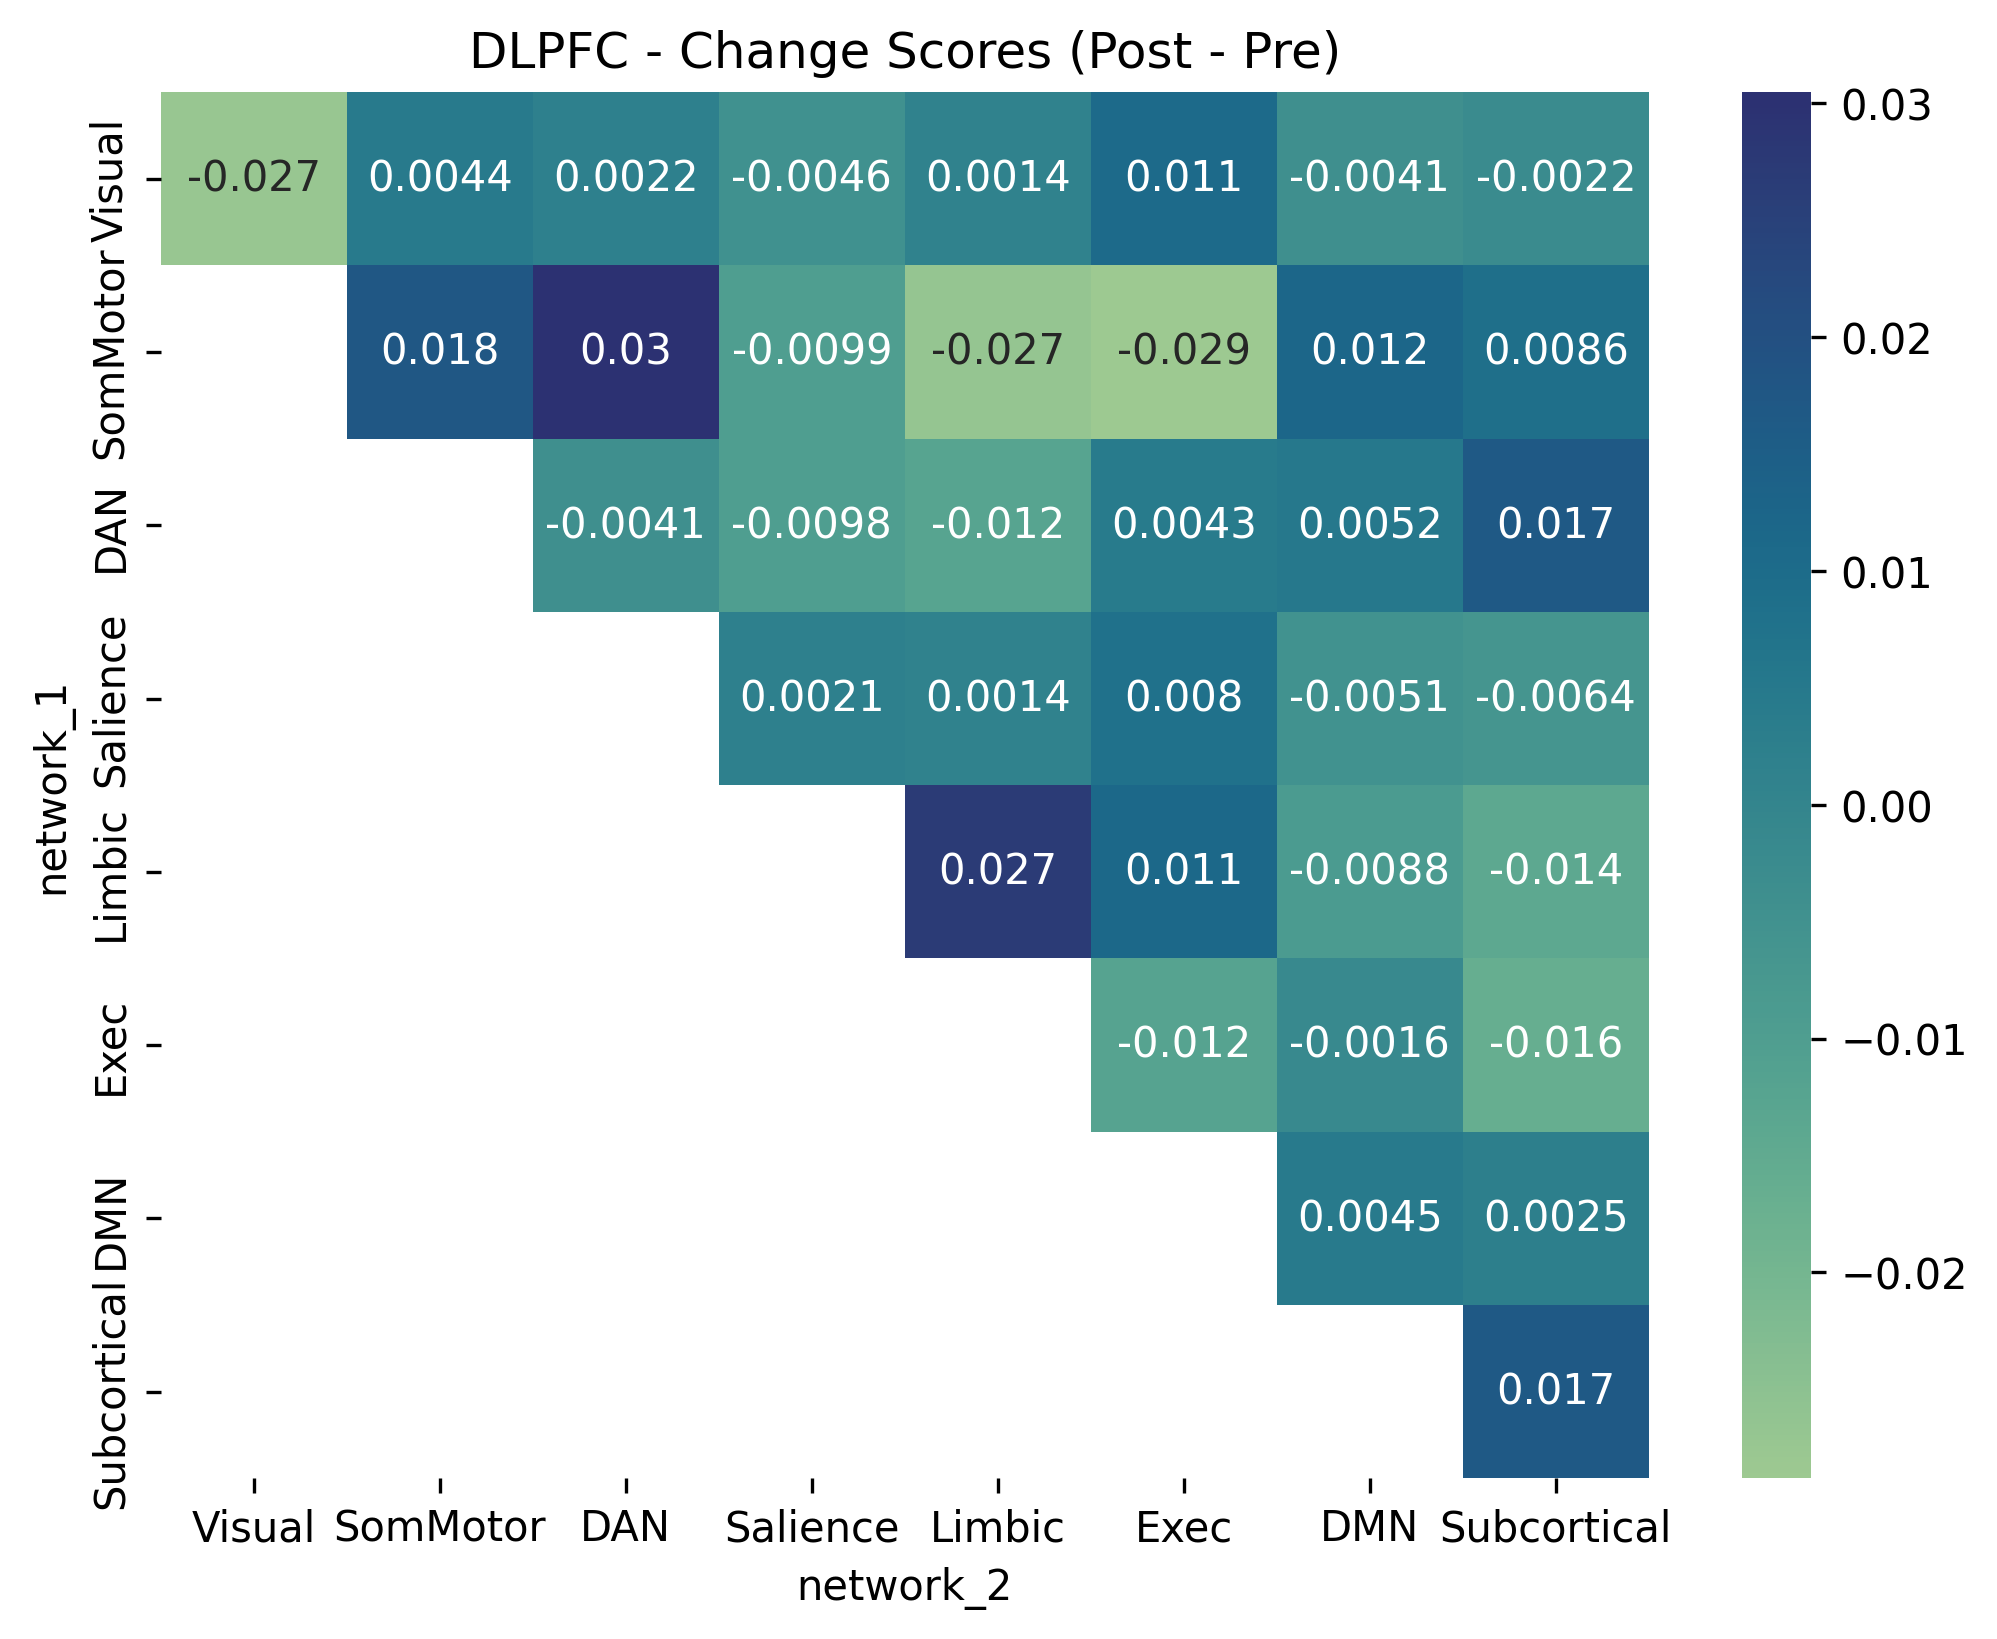

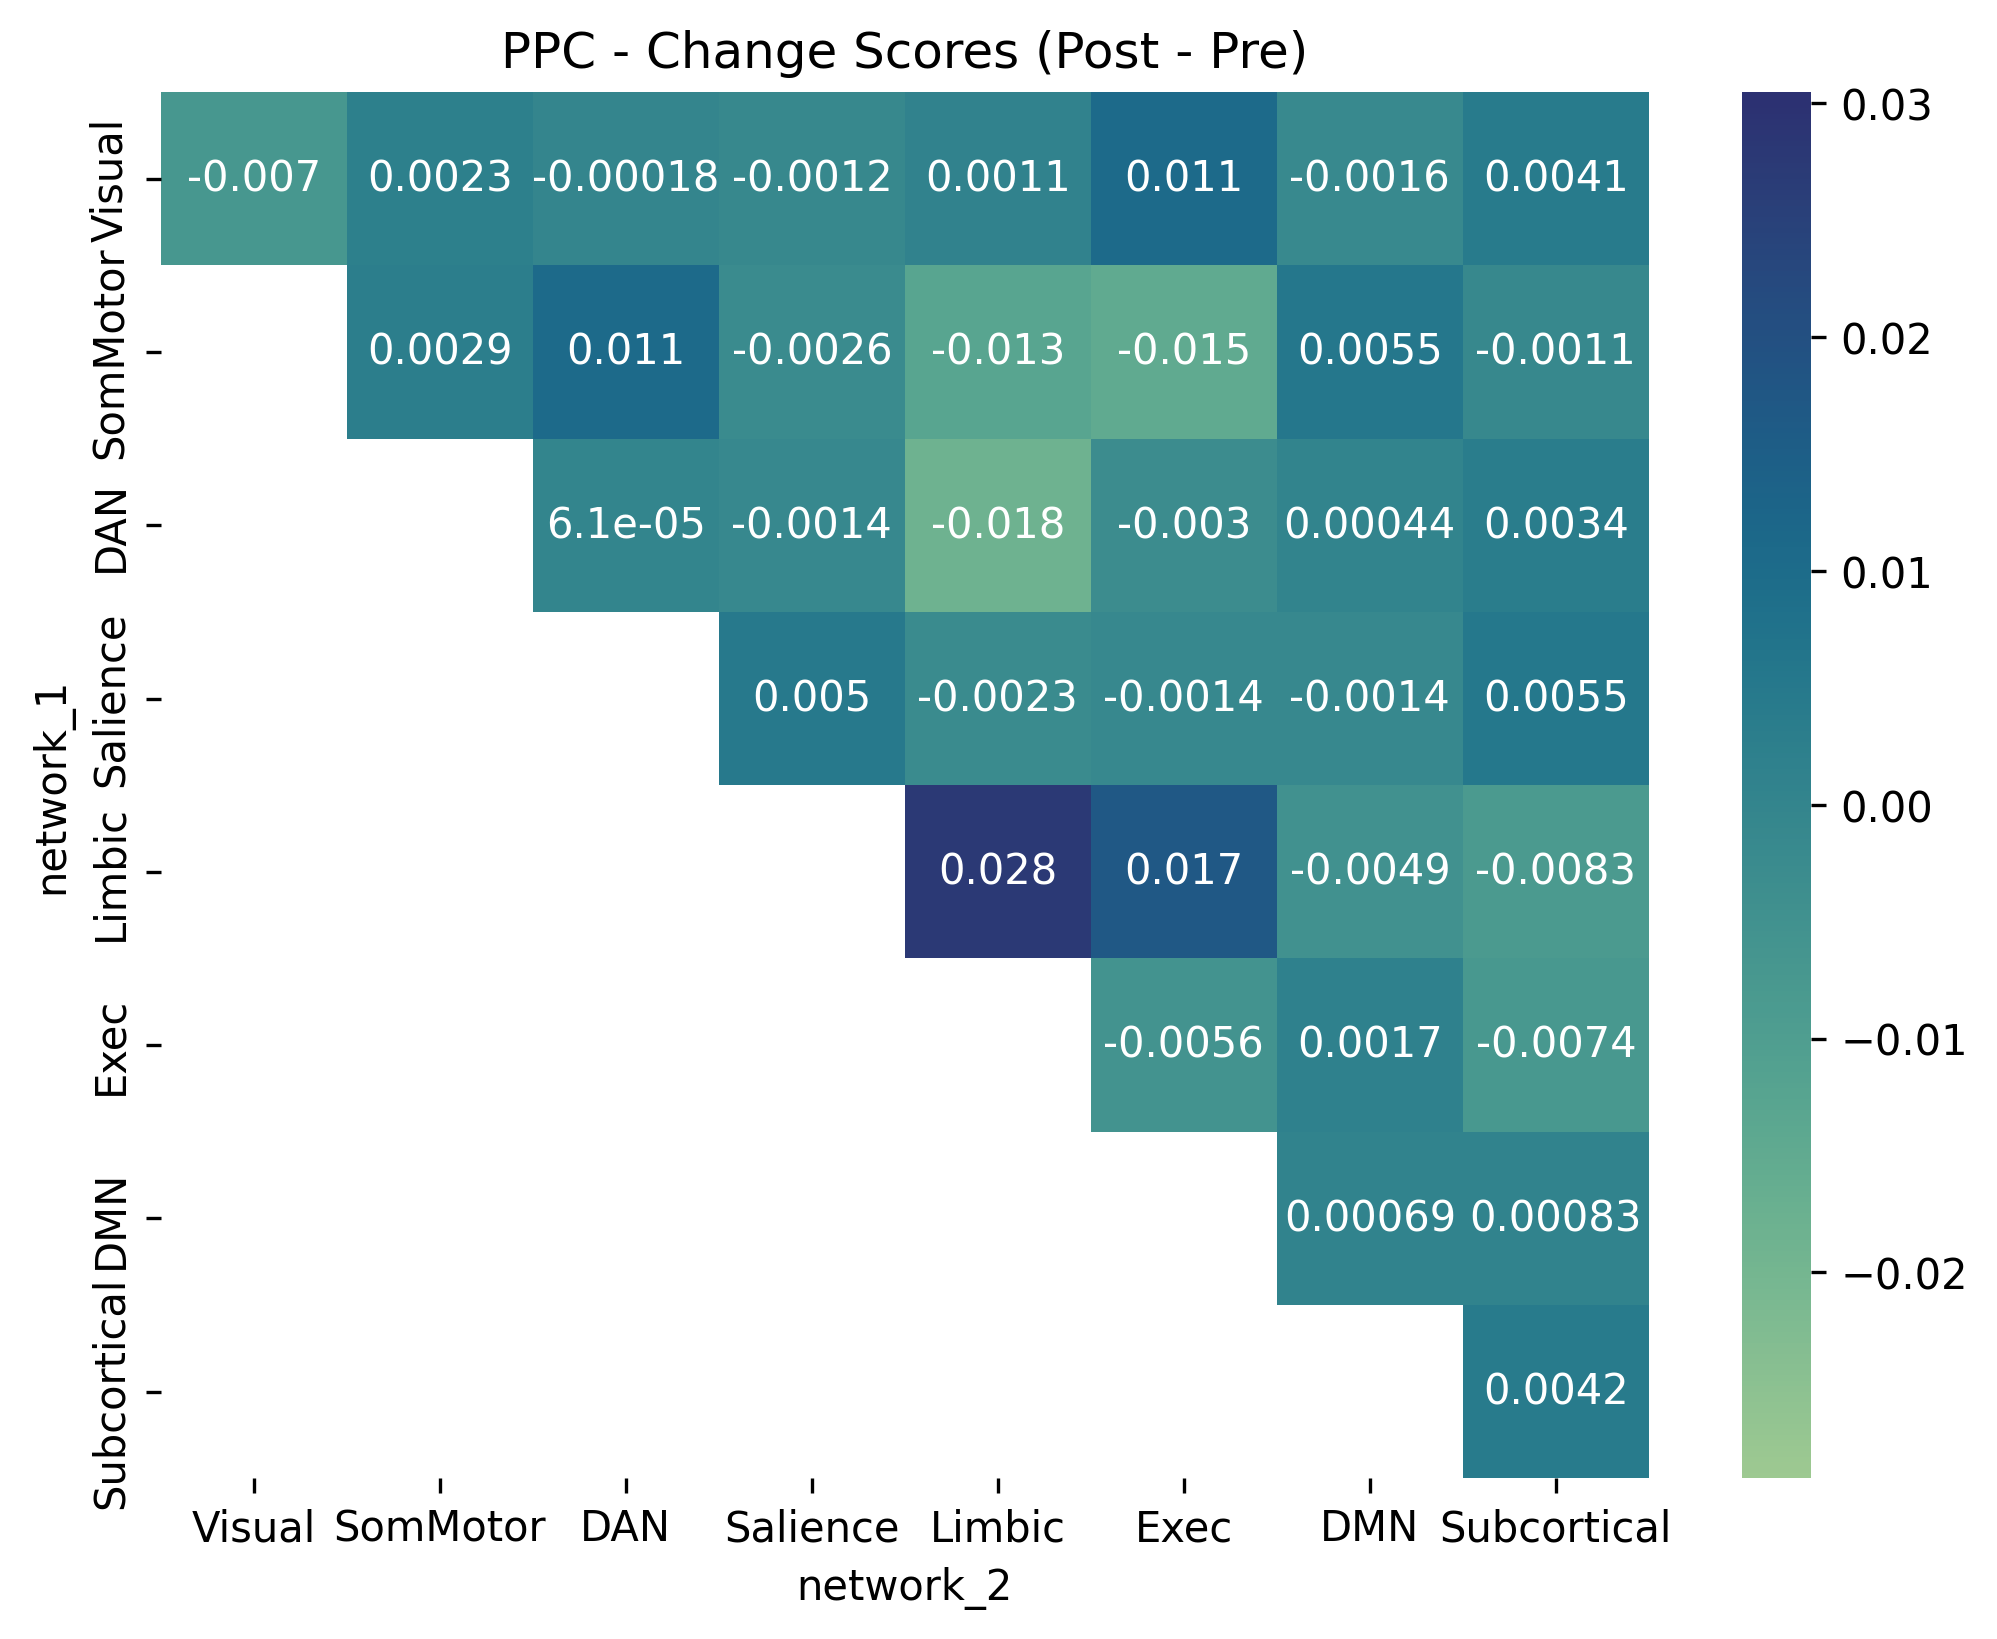

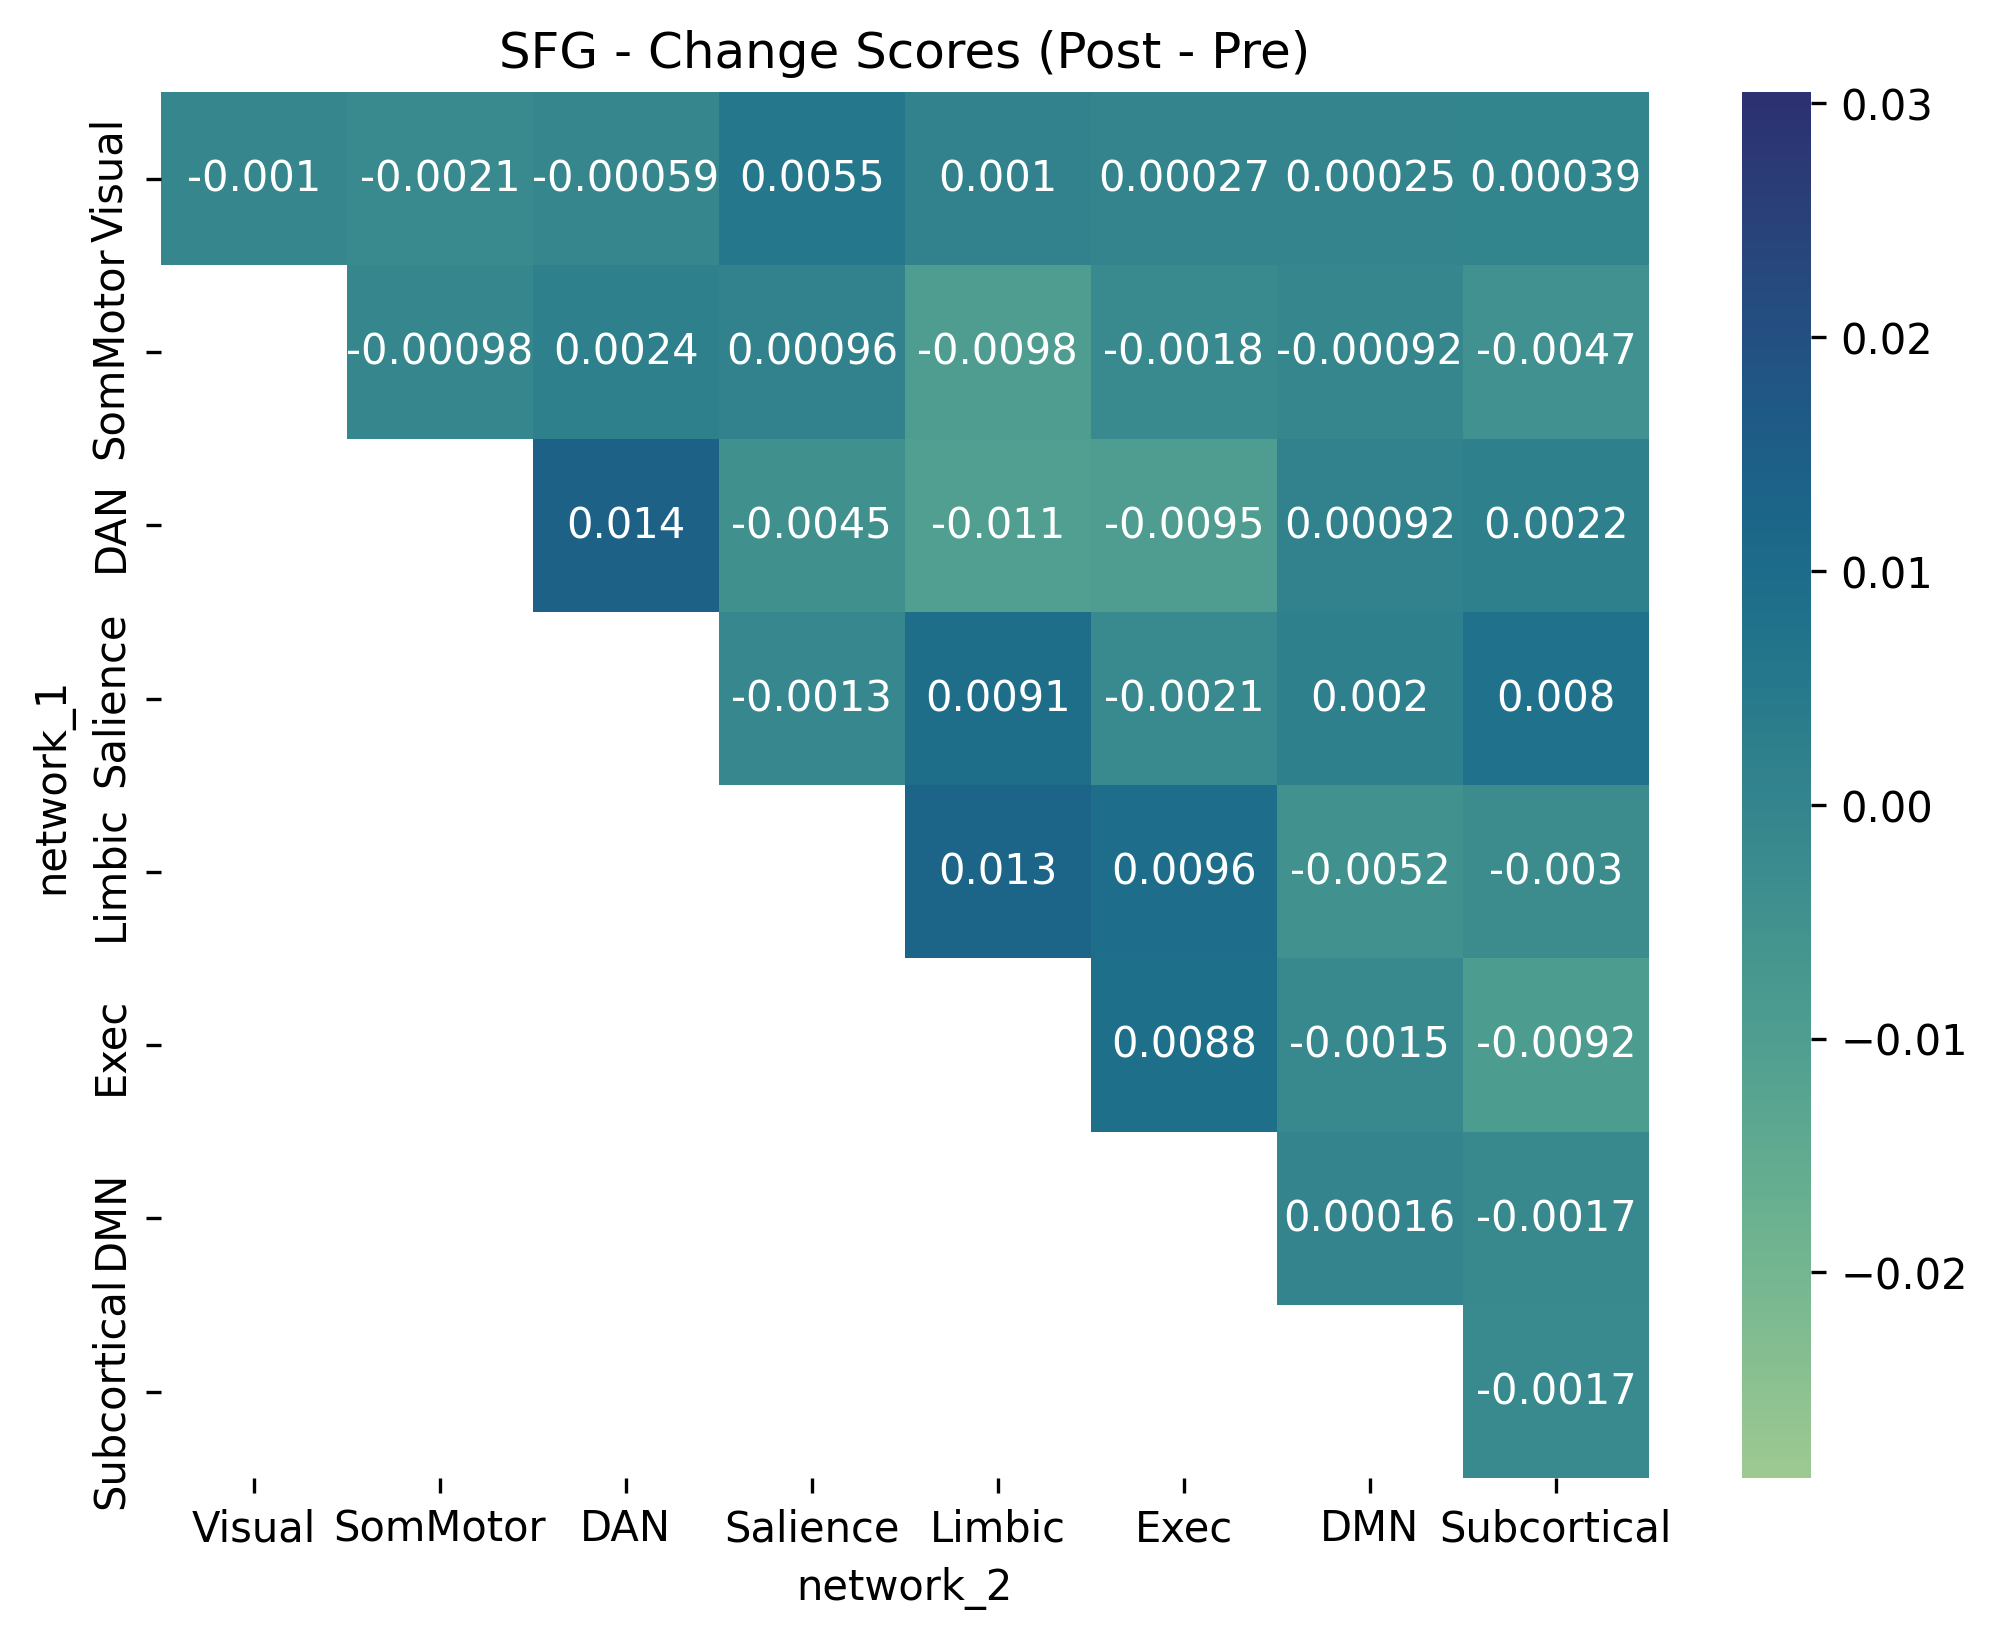

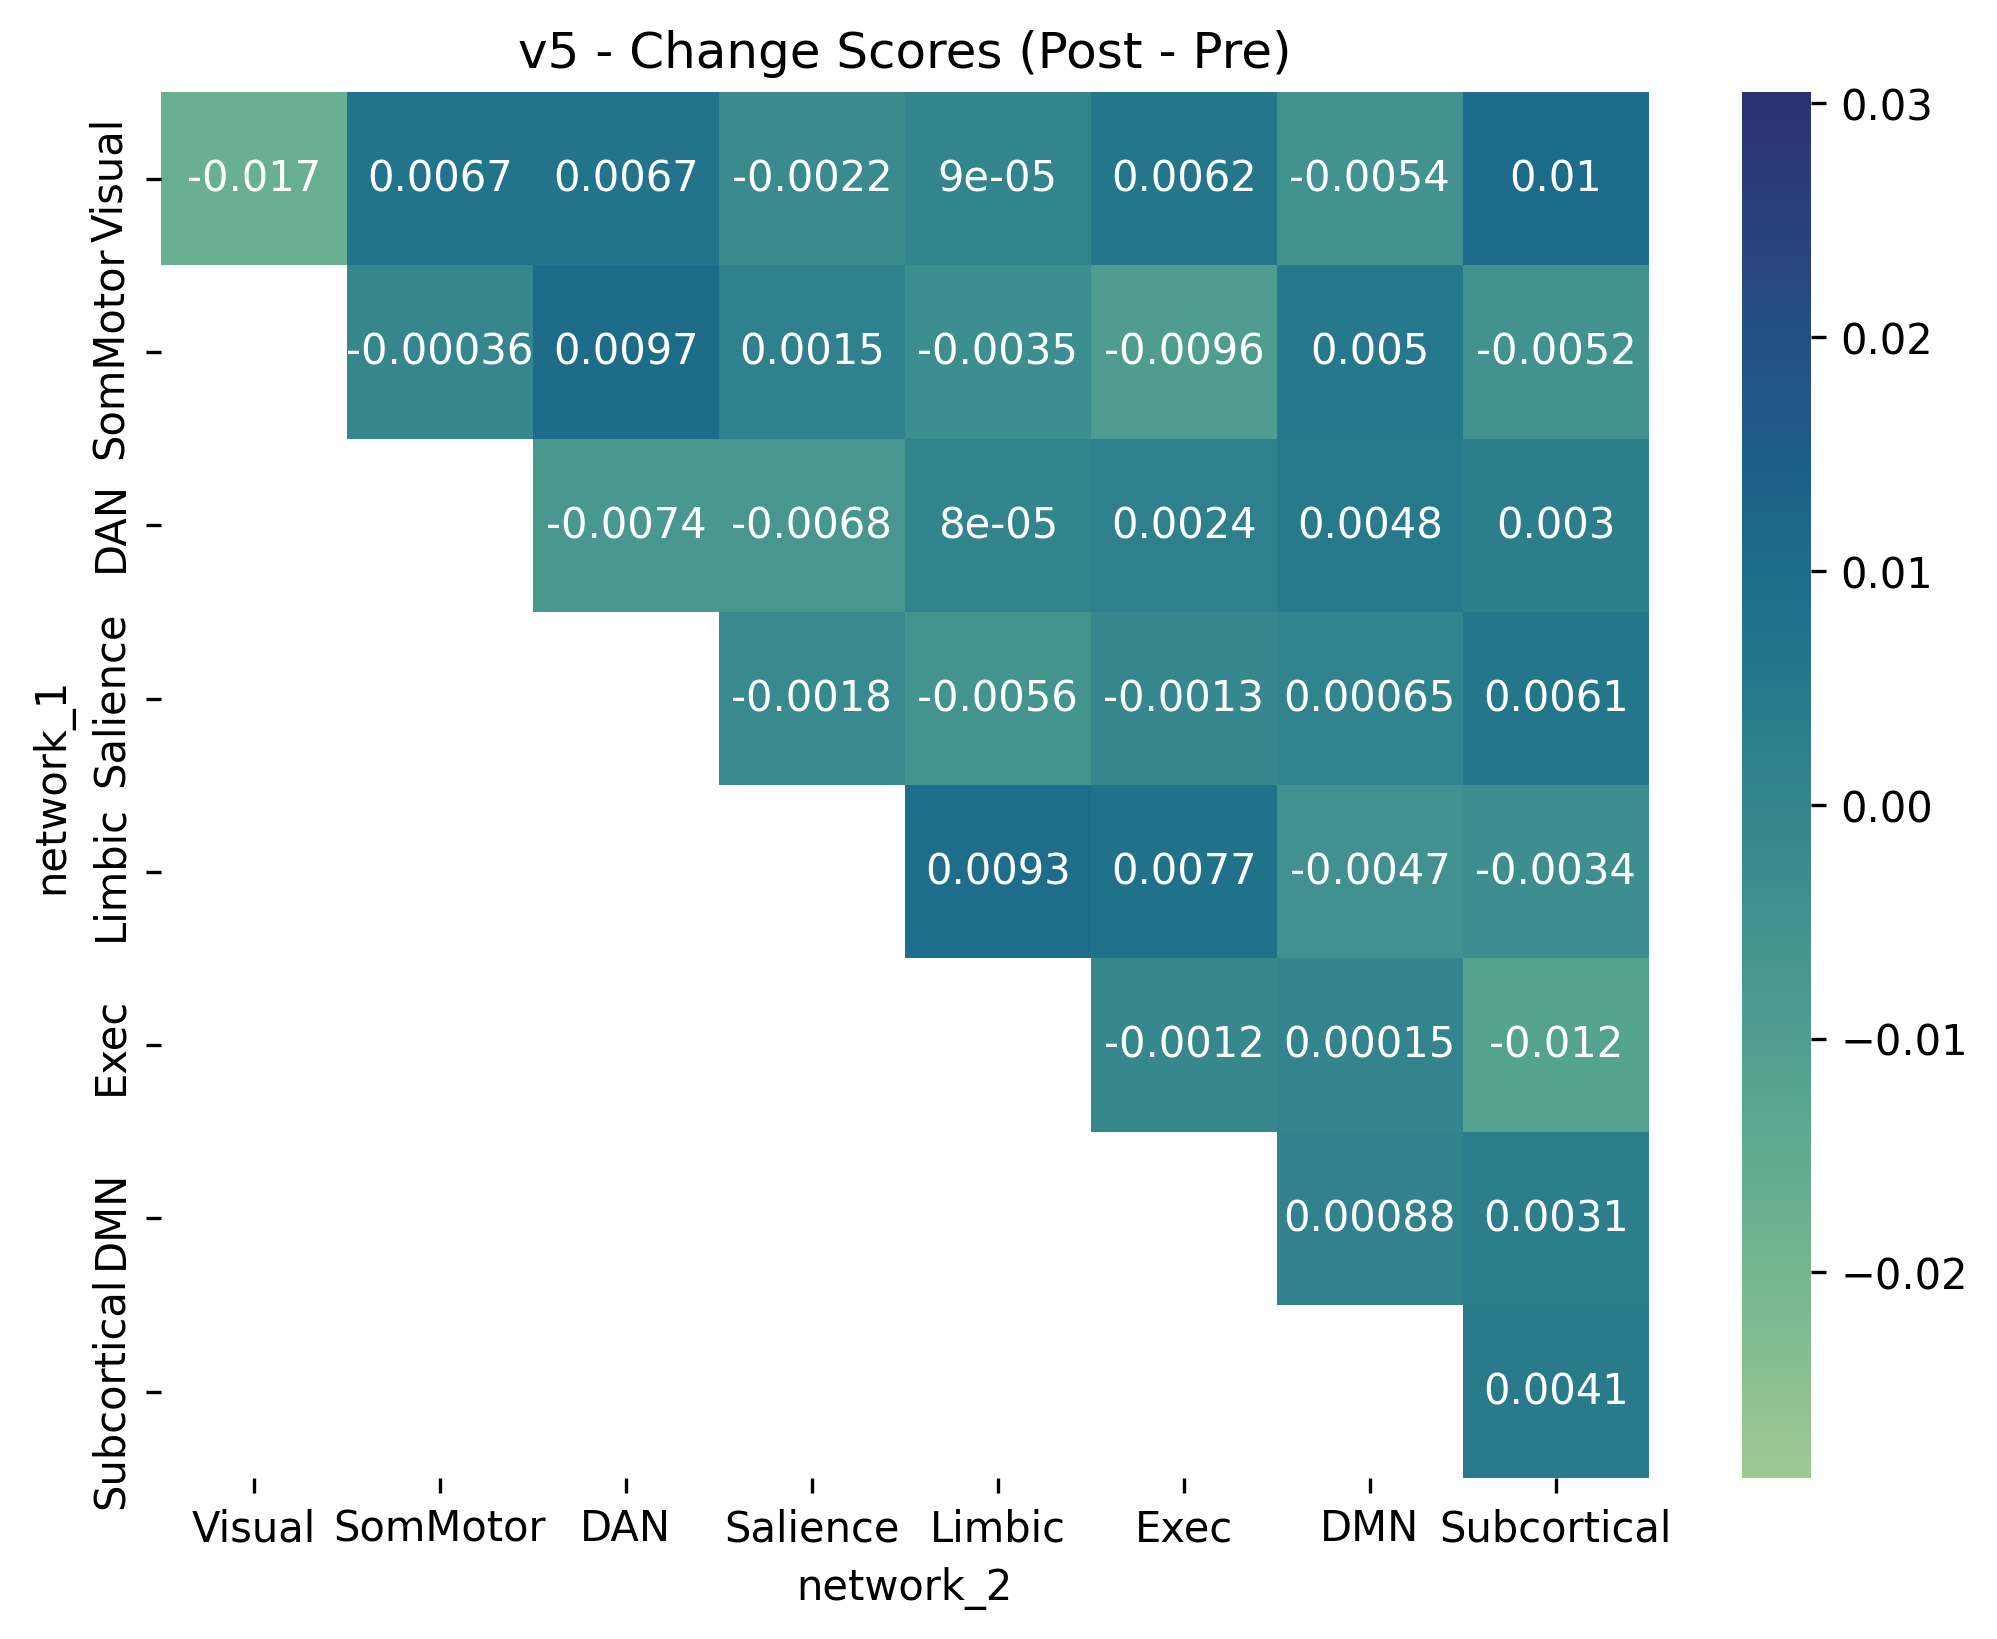

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress ConvergenceWarnings from statsmodels
warnings.filterwarnings('ignore', category=ConvergenceWarning)


# load data and define variables
file_path = '/u/home/n/npeterse/network_connectivity_averages.csv' 
df = pd.read_csv(file_path)
grouped = df.groupby(['target', 'session', 'network_1', 'network_2'])['average_connectivity'].mean().reset_index()

# make a pivot table to group pre and post variables, then calculate change scores
pivoted = grouped.pivot_table(index=['target', 'network_1', 'network_2'], columns='session', values='average_connectivity').reset_index()
pivoted['change'] = pivoted['post'] - pivoted['pre']

# order the networks to make matrix images make visual sense
network_order = ['Visual', 'SomMotor', 'DAN', 'Salience', 'Limbic', 'Exec', 'DMN', 'Subcortical']  

# find global max and min scores to scale all plots to the same... scale
global_min = pivoted['change'].min()
global_max = pivoted['change'].max()

# Function to generate heatmaps for each target based on change scores
def generate_change_heatmaps(pivoted_data):
    for target in pivoted_data['target'].unique():
        # Filter data for the current target
        data = pivoted_data[pivoted_data['target'] == target]
        
        # Pivot the data to create a matrix of network_1 vs network_2 for change scores
        heatmap_data = data.pivot(index='network_1', columns='network_2', values='change')
        
        # Reindex rows and columns based on the specified network order
        heatmap_data = heatmap_data.reindex(index=network_order, columns=network_order)
        
        # Plot the heatmap with consistent color scaling (vmin, vmax)
        plt.figure(figsize=(8, 6), dpi=300)
        sns.heatmap(heatmap_data, annot=True, cmap='crest', center=0, vmin=global_min, vmax=global_max)
        plt.title(f'{target} - Change Scores (Post - Pre)')
        plt.show()

# Step 8: Call the function to generate and display heatmaps for change scores
generate_change_heatmaps(pivoted)
